# **This is an implementation of Wasserstein GANs with gradient penalty.**
## **Link to the paper is : https://arxiv.org/pdf/1704.00028.pdf**

Wasserstein GANs suggest a change in the distance function calculated while training any Generative Adverserial Network.
Earth mover's distance is a weaker distance and in their paper,. 
The other distances like Total Variance, KL Divergence and JS Divergence failed in the case of low dimensional manifolds where the distributions may have very little common projection space.
The mathematical details of the advantages of this distance can be read here : https://arxiv.org/pdf/1701.07875.pdf


We can even use Resnet-101 as a generator in WGAN-GP but let's keep it simple and train it on a DC GAN architecture 
Go on to my repository https://github.com/spandan2/Wgan-GP_cats for an implementation with tensorboard support

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("/kaggle/input/cats-faces-64x64-for-generative-models/cats"))
os.chdir('..')
# Any results you write to the current directory are saved as output.

Let's import our dependencies

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import shutil
import statistics as st
import matplotlib.image as mpimg
import pylab

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

> While defining the architecture of discriminators and Generators, we found that instead of rewriting blocks we can use functions to define blocks with much less repitition of code

In [ ]:
class generator(nn.Module):
    def __init__(self, dim_in, dim=64):
        super(generator,self).__init__()
        def genblock(dim_in, dim_out):
            block = nn.Sequential( nn.ConvTranspose2d(in_channels = dim_in, 
                                                      out_channels = dim_out,
                                                      kernel_size = 5, 
                                                      stride=2, 
                                                      padding=2,
                                                      output_padding = 1,
                                                      bias = False),
                                    nn.BatchNorm2d(dim_out),
                                    nn.ReLU()
                                    )
            return block
        def genimg(dim_in):
            block = nn.Sequential( nn.ConvTranspose2d(in_channels = dim_in, 
                                                      out_channels = 3,
                                                      kernel_size = 5, 
                                                      stride=2, 
                                                      padding=2,
                                                      output_padding = 1,
                                                      ),
                                    nn.Tanh()
                                    )
            return block
        
        self.prepare = nn.Sequential(nn.Linear(dim_in, dim*8*4*4, bias=False),
                                     nn.BatchNorm1d(dim*8*4*4),
                                     nn.ReLU())
        
        self.generate = nn.Sequential(genblock(dim*8, dim*4),
                                      genblock(dim*4, dim*2),
                                      genblock(dim*2, dim),
                                      genimg(dim))
    def forward(self, x):
        x = self.prepare(x)
        x = x.view(x.size(0), -1,4,4)
        x = self.generate(x)
        return x
#%%
class critic(nn.Module):
    def __init__(self, dim_in, dim=64):
        super(critic, self).__init__()
        
        def critic_block(dim_in , dim_out):
            block = nn.Sequential(nn.Conv2d(in_channels = dim_in, 
                                            out_channels = dim_out,
                                            kernel_size = 5, 
                                            stride=2, 
                                            padding=2),
                                    nn.InstanceNorm2d(dim_out, affine= True),
                                    nn.LeakyReLU(0.2))
            return block
        self.analyze = nn.Sequential(nn.Conv2d(in_channels = dim_in, 
                                               out_channels = dim,
                                               kernel_size = 5, 
                                               stride=2, 
                                               padding=2),
                                     nn.LeakyReLU(0.2),
                                     critic_block(dim,dim*2),
                                     critic_block(dim*2,dim*4),
                                     critic_block(dim*4, dim*8),
                                     nn.Conv2d(in_channels=dim*8, 
                                               out_channels=1,
                                               kernel_size=4))
    def forward(self,x):
        x = self.analyze(x)
        x =x.view(-1)
        return x

**As mentioned in the paper, WGANs require a Lipschitz condition which on a high level can be understood as clipping the weights to a certain limit.
WGAN-GP enforces this Lipschitz condition not by clipping weights but by using a gradient penalty that is learnable unlike a hardcoded clipping.**


Other utilities have been defined for checkpointing and for saving images

In [1]:
C

NameError: name 'C' is not defined

In [7]:
def gradient_penalty(x,y,f):
    shape =[x.size(0)] + [1] * (x.dim() -1)
    alpha = torch.rand(shape).cuda()
    z = x+ alpha *(y-x)
    z = Variable(z,requires_grad=True)
    z=z.cuda()
    o=f(z)
    g = grad(o,z, grad_outputs=torch.ones(o.size()).cuda(), create_graph=True)[0].view(z.size(0), -1)
    gp = ((g.norm(p=2,dim=1))**2).mean()
    return gp
#%%
def save_checkpoint(state, save_path, is_best=False, max_keep=None):
    # save checkpoint
    torch.save(state, save_path)

    # deal with max_keep
    save_dir = os.path.dirname(save_path)
    list_path = os.path.join(save_dir, 'latest_checkpoint')

    save_path = os.path.basename(save_path)
    if os.path.exists(list_path):
        with open(list_path) as f:
            ckpt_list = f.readlines()
            ckpt_list = [save_path + '\n'] + ckpt_list
    else:
        ckpt_list = [save_path + '\n']

    if max_keep is not None:
        for ckpt in ckpt_list[max_keep:]:
            ckpt = os.path.join(save_dir, ckpt[:-1])
            if os.path.exists(ckpt):
                os.remove(ckpt)
        ckpt_list[max_keep:] = []

    with open(list_path, 'w') as f:
        f.writelines(ckpt_list)

    # copy best
    if is_best:
        shutil.copyfile(save_path, os.path.join(save_dir, 'best_model.ckpt'))
#%%
def load_checkpoint(ckpt_dir_or_file, map_location=None, load_best=False):
    if os.path.isdir(ckpt_dir_or_file):
        if load_best:
            ckpt_path = os.path.join(ckpt_dir_or_file, 'best_model.ckpt')
        else:
            with open(os.path.join(ckpt_dir_or_file, 'latest_checkpoint')) as f:
                ckpt_path = os.path.join(ckpt_dir_or_file, f.readline()[:-1])
    else:
        ckpt_path = ckpt_dir_or_file
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

**Let us now train the model . GANs converge noise data to a distribution. Here, the noise data is 100 dimensional. 
Note that the critic here has 3 channels as input as it must take an RGB image and segregate it from the real images.**

In [53]:
epochs = 400 #Ideally go for 500+ epochs . Less epochs have been taken just for the purpose of this notebook
batch_size = 180
n_critic=5
lr=0.0002
z_dim = 100
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
data = torchvision.datasets.ImageFolder('/kaggle/input/cats-faces-64x64-for-generative-models/cats', transform = transform)
dataloader = torch.utils.data.DataLoader(data,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=3)
C = critic(3)
G = generator(z_dim)
C = C.cuda()
G = G.cuda()
print(C)
print(G)
print("Generator : ")
print(G)
print("Critic")
print(C)
start_epoch=0
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
C_opt = torch.optim.Adam(C.parameters(), lr=lr, betas=(0.5,0.999))
#%%
checkpoint = 'checkpoints/wgan_gp'
save_dir = '/kaggle/working/sample_images/wgan_gp'
if not isinstance(checkpoint, (list, tuple)):
    paths = [checkpoint]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)
if not isinstance(save_dir, (list, tuple)):
    paths = [save_dir]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)
try:
    ckpt = load_checkpoint(checkpoint)
    start_epoch = ckpt['epoch']
    C.load_state_dict(ckpt['D'])
    G.load_state_dict(ckpt['G'])
    C_opt.load_state_dict(ckpt['d_optimizer'])
    G_opt.load_state_dict(ckpt['g_optimizer'])
except:
    print(' [*] No checkpoint!')
    start_epoch = 0
#%%
z_sample = Variable(torch.randn(100, z_dim)).cuda()


critic(
  (analyze): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)
generator(
  (prepare): Sequential(
    (0): Linear(in_featur

In [56]:
import time
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    C_loss= []
    G_loss=[]
    G.train()
    for i, (images, _) in enumerate(dataloader):
        step = epoch * len(dataloader) + i + 1

        images = Variable(images)
        batch = images.size(0)
        images = images.cuda()
        z = Variable(torch.randn(batch, z_dim))
        z = z.cuda()
        
        generated = G(z)
        real_criticized = C(images)
        fake_criticized = C(generated)
        
        em_distance = real_criticized.mean() - fake_criticized.mean()
        grad_penalty = gradient_penalty(images.data, generated.data, C)
        
        CriticLoss = -em_distance + grad_penalty*10
        C_loss.append(CriticLoss.item())
        C.zero_grad()
        CriticLoss.backward()
        C_opt.step()
        
        if step % n_critic == 0:
            z = Variable(torch.randn(batch, z_dim))
            z = z.cuda()
            generated = G(z)
            fake_criticized = C(generated)
            GenLoss = -fake_criticized.mean()
            G_loss.append(GenLoss.item())
            C.zero_grad()
            G.zero_grad()
            GenLoss.backward()
            G_opt.step()
            print("Epoch {} : {}/{} :: {} mins".format(epoch+1, i+1, len(dataloader), (time.time()-start_time)/60), end='\r')         
#             print(f"Generator Loss is:,{GenLoss.item()}")
            
    print("Epoch {} completed".format(epoch+1))
    G.eval()
    fake_gen_images = (G(z_sample).data +1)/2.0
    torchvision.utils.save_image(fake_gen_images, save_dir+'/Epoch '+str(epoch+1)+".jpg",nrow=10)
    
    # Save checkpoint every 50 epochs
    if (epoch + 1) % 5 == 0:

        save_checkpoint({'epoch': epoch + 1,
                               'D': C.state_dict(),
                               'G': G.state_dict(),
                               'd_optimizer': C_opt.state_dict(),
                               'g_optimizer': G_opt.state_dict()},
                              '/kaggle/working/Epoch_(%d).ckpt' % ( epoch + 1),
                              max_keep=2)
    

Epoch 1 completed: 1.274600879351298 minsss
Epoch 2 completed: 1.306609078248342 minsss
Epoch 3 completed: 1.2605509678522746 minss
Epoch 4 completed: 1.2925811052322387 minss
Epoch 5 completed: 1.3123904109001159 minss
Epoch 6 completed: 1.2744091987609862 minss
Epoch 7 completed: 1.3067413846651712 minss
Epoch 8 completed: 1.2607153495152792 minss
Epoch 9 completed: 1.2923339366912843 minss
Epoch 10 completed: 1.3121132493019103 minss
Epoch 11 completed: 1.2753931919733683 minss
Epoch 12 completed: 1.30679136912028 minssss
Epoch 13 completed: 1.2602139512697856 minss
Epoch 14 completed: 1.2921306451161703 minss


KeyboardInterrupt: 

In [1]:
# # Save generator model and optimizer state
# torch.save({
#     'epoch': epoch,  # Current epoch number
#     'model_state_dict': G.state_dict(),  # Model's state dictionary
#     'optimizer_state_dict': G_opt.state_dict()  # Optimizer's state dictionary
# }, '/kaggle/working/generator_checkpoint_250.pth')

# # Save critic model and optimizer state
# torch.save({
#     'epoch': epoch,  # Current epoch number
#     'model_state_dict': C.state_dict(),  # Model's state dictionary
#     'optimizer_state_dict': C_opt.state_dict()  # Optimizer's state dictionary
# }, '/kaggle/working/critic_checkpoint_250.pth')

NameError: name 'torch' is not defined

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

z_dim = 100

# # Define the generator model
# G = generator(z_dim)



# Define the optimizer for the generator (assuming SGD for example)
# G_opt = optim.SGD(G.parameters(), lr=0.001)

# Load the checkpoint
checkpoint_path = '/kaggle/input/wgan-gp-250-epochs/pytorch/default/1/generator_checkpoint_250.pth'
checkpoint = torch.load(checkpoint_path)

# Load model's state_dict
G.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer's state_dict
G_opt.load_state_dict(checkpoint['optimizer_state_dict'])

# Optional: Load other items saved in the checkpoint
epoch = checkpoint['epoch']

G.cuda()
# Now G and G_opt are loaded and ready to be used for inference or further training



######################

# C = critic(3)


# # Define the optimizer for the generator (assuming SGD for example)
# C_opt = optim.SGD(G.parameters(), lr=0.001)

# # Load the checkpoint
# checkpoint_path = '/kaggle/input/wgan-gp-250-epochs/pytorch/default/1/critic_checkpoint_250.pth'
# checkpoint = torch.load(checkpoint_path)

# # Load model's state_dict
# C.load_state_dict(checkpoint['model_state_dict'])

# # Load optimizer's state_dict
# # C_opt.load_state_dict(checkpoint['optimizer_state_dict'])

# # Optional: Load other items saved in the checkpoint
# epoch = checkpoint['epoch']

# C.cuda()
# # Now G and G_opt are loaded and ready to be used for inference or further training


generator(
  (prepare): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (generate): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2)

torch.Size([2, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


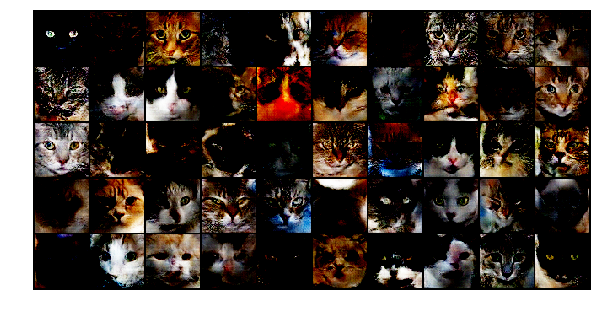

In [64]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Generate 20 images
z_dim = 100  # Make sure z_dim matches your generator's input dimension
batch_size = 50
z = torch.randn(batch_size, z_dim).cuda()
out = G(z)

# Convert the images to numpy arrays
out_images = out.detach().cpu().numpy()

# Convert from (C, H, W) to (H, W, C) for plotting
out_images = [img.transpose(1, 2, 0) for img in out_images]

# Create a grid of images
grid = torchvision.utils.make_grid(out, nrow=10)  # Arrange in 5 columns

# Convert grid to numpy array for plotting
grid_image = grid.permute(1, 2, 0).cpu().detach().numpy()

# Plot the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid_image)
plt.axis('off')  # Hide axes
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


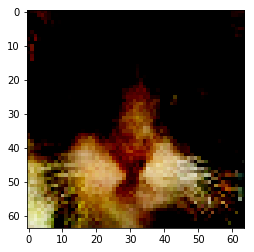

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


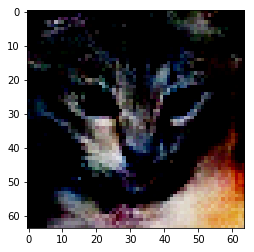

In [16]:
out_image0 = out[0].detach().cpu().numpy()
out_image1 = out[1].detach().cpu().numpy()


# Convert from (C, H, W) to (H, W, C) for plotting if necessary
out_image0 = out_image0.transpose(1, 2, 0)
out_image1 = out_image1.transpose(1, 2, 0)

plt.figure(figsize=(4, 4))# Plot the image
plt.imshow(out_image0)
plt.show()
plt.figure(figsize=(4, 4))# Plot the image

plt.imshow(out_image1)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


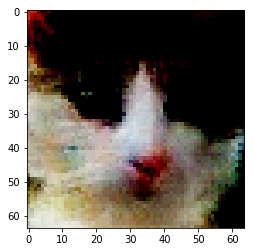

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


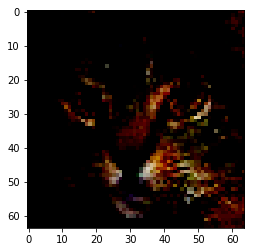

In [68]:
z = Variable(torch.randn(2, z_dim))
z = z.cuda()
out=G(z)
out.shape


out_image0 = out[0].detach().cpu().numpy()
out_image1 = out[1].detach().cpu().numpy()


# Convert from (C, H, W) to (H, W, C) for plotting if necessary
out_image0 = out_image0.transpose(1, 2, 0)
out_image1 = out_image1.transpose(1, 2, 0)

plt.figure(figsize=(4, 4))# Plot the image
plt.imshow(out_image0)
plt.show()
plt.figure(figsize=(4, 4))# Plot the image

plt.imshow(out_image1)

plt.show()

# **Outputs as trained in this notebook**

In [ ]:
a= os.listdir('sample_images/wgan_gp/')
a.sort()
print(a[-1])
img=mpimg.imread('sample_images/wgan_gp/'+a[-1])
plt.imshow(img)
plt.axis('off')
plt.show()

# Output after training for 500 epochs

In [ ]:
!wget https://raw.githubusercontent.com/spandan2/Wgan-GP_cats/master/sample_images/wgan_gp/Epoch%20500.jpg
img=mpimg.imread('Epoch 500.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()